#Overview

**This project focuses on developing a bi-directional LSTM model for detecting hate speech in tweets. The dataset consists of labeled tweets, which are preprocessed by removing URLs, mentions, special characters, and expanding contractions. The data is then tokenized, padded, and balanced through downsampling to address class imbalance. The model architecture includes a bi-directional LSTM with dropout and batch normalization layers to improve generalization. WandB is used for tracking and visualizing training progress. The model is trained with early stopping to prevent overfitting. After training, the model is evaluated using accuracy and a confusion matrix. The model shows good performance, classifying tweets as either hate speech or not. The final model is saved and can be used for real-time prediction on new tweets.**

# Installing necessary packages


In [1]:
!pip install uv
!uv pip install emoji contractions wandb --system

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 88.0 MB/s eta 0:00:00
Using Python 3.10.12 environment at: /usr
Resolved 25 packages in 743ms
⠙ Preparing packages... (0/5)
⠙ Preparing packages... (0/5)
⠙ Preparing packages... (0/5)
textsearch ------------------------------ 7.43 KiB/7.43 KiB
⠙ Preparing packages... (0/5)
⠙ Preparing packages... (0/5)
⠙ Preparing packages... (0/5)
⠙ Preparing packages... (0/5)
⠙ Preparing packages... (0/5)
⠙ Preparing packages... (0/5)
contractions ------------------------------     0 B/8.45 KiB
⠙ Preparing packages... (0/5)
contractions ------------------------------     0 B/8.45 KiB
pyahocorasick ------------------------------ 62.22 KiB/108.12 KiB
⠙ Preparing packages... (0/5)
contractions ------------------------------     0 B/8.45 KiB
pyahocorasick ------------------------------ 62.22 KiB/108.12 KiB
⠙ Preparing packages... (0/5)
contractions ------------------------------     0 B/8.45 KiB
pyahocorasick ------------------------------ 62.22 Ki

# Importing the necessary packages

1. Data processing and visualization libraries
2. Scikit-learn, TensorFlow, NLTK, WandB, Transformers, and other cleaning libraries


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import warnings
import nltk
from tqdm import tqdm
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
import emoji
import contractions
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import class_weight

import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint
from tqdm import tqdm
from transformers import pipeline

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import spacy

warnings.filterwarnings("ignore")

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

from nltk.data import find
try:
    find('corpora/wordnet.zip')
    print("WordNet corpus found!")
except LookupError:
    print("WordNet corpus not found!")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


WordNet corpus found!


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


# WandB for moniter traning and resources

In [3]:
wandb.init(project="hate-speech-classification")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Reading The Hate speech data


In [4]:
df_train = pd.read_csv('//content//train.csv', usecols=[1,2])
df_test = pd.read_csv('//content//test.csv', usecols=[1])

# Exploratory data analysis

**Train Data**

In [5]:
df_train.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


**Test Data**

In [6]:
df_test.head()

,tweet
0,#studiolife #aislife #requires #passion #dedic...
1,@user #white #supremacists want everyone to s...
2,safe ways to heal your #acne!! #altwaystohe...
3,is the hp and the cursed child book up for res...
4,"3rd #bihday to my amazing, hilarious #nephew..."


**We can see no header in data then i will add header**

In [12]:
print("The shape of the training dataset:", df_train.shape)
print("The shape of the test dataset:", df_test.shape)

The shape of the training dataset: (31962, 2)
The shape of the test dataset: (17197, 1)


In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   31962 non-null  int64 
 1   tweet   31962 non-null  object
dtypes: int64(1), object(1)
memory usage: 499.5+ KB


In [14]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17197 entries, 0 to 17196
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   17197 non-null  object
dtypes: object(1)
memory usage: 134.5+ KB


In [15]:
print("Number of duplicate rows in train data: ", df_train.duplicated().sum())
print("Number of duplicate rows in test data: ", df_test.duplicated().sum())

Number of duplicate rows in train data:  2432
Number of duplicate rows in test data:  1067


In [16]:
print("Number of duplicate rows in train data:")
print(df_train.isnull().sum(), "\n",30*"-")
print("Number of duplicate rows in test data:")
print(df_test.isnull().sum(), "\n",30*"-")

Number of duplicate rows in train data:
label    0
tweet    0
dtype: int64 
 ------------------------------
Number of duplicate rows in test data:
tweet    0
dtype: int64 
 ------------------------------


# Cleaning the Data

In [17]:
df_train.dropna(inplace=True)
df_train.isnull().sum()

,0
label,0
tweet,0


In [18]:
df_train.drop_duplicates(inplace=True)
df_train.duplicated().sum()

0

# Preprocessing the Data

In [19]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
Regex_tokenizer = RegexpTokenizer(r'\w+')

def clean_tweet(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.encode('ascii', 'ignore').decode('ascii')
    text = re.sub(r'\s+', ' ', text)
    text = contractions.fix(text)
    text = ' '.join([lemmatizer.lemmatize(word) for word in Regex_tokenizer.tokenize(text)])
    text = emoji.demojize(text)
    text = str(text.lower())
    return text

df_train['tweet'] = df_train['tweet'].apply(clean_tweet)
df_test['tweet'] = df_test['tweet'].apply(clean_tweet)

# Post processing

In [20]:
df_train = df_train.dropna(subset=['tweet'])
df_test = df_test.dropna(subset=['tweet'])

df_train = df_train[df_train['tweet'].str.strip() != '']
df_test = df_test[df_test['tweet'].str.strip() != '']

In [21]:
print("Number of duplicate data present in train data set after post processing", df_train.duplicated().sum())
df_train = df_train.drop_duplicates(subset=['tweet'])

Number of duplicate data present in train data set after post processing 2284


# Label Prediction for Unlabeled Test Data Using Pre-trained Model

In [22]:
from transformers import pipeline
pipe = pipeline('text-classification', model="citizenlab/twitter-xlm-roberta-base-sentiment-finetunned", device=0)

config.json:   0%|          | 0.00/992 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/618 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [23]:
def map_to_binary_label(label):
    return {"Positive": 0, "Neutral": 0, "Negative": 1}.get(label, 0)
batch_size = 32
batches = [df_test['tweet'][i:i+batch_size] for i in range(0, len(df_test), batch_size)]

labels = []

for batch in tqdm(batches, desc="Processing tweets", unit="batch"):
    batch = batch.tolist()
    predictions = pipe(batch)
    batch_labels = [map_to_binary_label(pred['label']) for pred in predictions]
    labels.extend(batch_labels)

df_test['label'] = labels

print(df_test.head())

Processing tweets: 100%|██████████| 536/536 [02:36<00:00,  3.42batch/s]

                                               tweet  label
0                                            to find      0
1       want everyone to see the new and here is why      0
2                              safe way to heal your      0
3  is the hp and the cursed child book up for res...      0
4  rd to my amazing hilarious eli ahmir uncle dav...      0


In [24]:
print("Count of unique values in train data:")
print(df_train['label'].value_counts(), "\n",30*"-")

print("Count of unique values in test data:")
print(df_test['label'].value_counts(), "\n",30*"-")

Count of unique values in train data:
label
0    25349
1     1787
Name: count, dtype: int64 
 ------------------------------
Count of unique values in test data:
label
0    15245
1     1894
Name: count, dtype: int64 
 ------------------------------


In [25]:
df_test.to_csv('new_test.csv', index=False)
df_test = pd.read_csv('new_test.csv')

In [26]:
df_majority = df_test[df_test['label'] == 0]
df_minority = df_test[df_test['label'] == 1]

df_majority_downsampled = resample(df_majority,
                                   replace=False,
                                   n_samples=len(df_minority),
                                   random_state=42)

df_test = pd.concat([df_majority_downsampled, df_minority])

print(df_test['label'].value_counts())

label
0    1894
1    1894
Name: count, dtype: int64


# Split the Data

In [27]:
train_texts = df_train['tweet'].values
train_labels = df_train['label'].values
test_texts = df_test['tweet'].values
test_labels = df_test['label'].values

# Class weighting

In [28]:
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weight_dict = dict(zip(np.unique(train_labels), class_weights))

print("Class weights:", class_weight_dict)

Class weights: {0: 0.5352479387747051, 1: 7.592613318410744}


In [29]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)
tokenizer.fit_on_texts(test_texts)

In [30]:
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

In [31]:
maxlen = max(len(tokens) for tokens in train_sequences)
print("Maximum sequence length (maxlen):", maxlen)

Maximum sequence length (maxlen): 33


In [32]:
train_padded = pad_sequences(train_sequences, maxlen=maxlen, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=maxlen, padding='post')

In [33]:
input_size = np.max(train_padded) + 1
input_size

20724

# Building the Model

In [34]:
model = Sequential()
model.add(Embedding(input_dim=input_size, output_dim=100, input_length=33))
#BI-Dir LSTM
model.add(Bidirectional(LSTM(128, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), return_sequences=True)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
#BI-Dir LSTM
model.add(Bidirectional(LSTM(64, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01))))
model.add(BatchNormalization())
model.add(Dropout(0.25))
#Dense
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.25))
#Output
model.add(Dense(2, activation='softmax'))

In [35]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [36]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [37]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
train_history = model.fit(
    train_padded,
    train_labels ,
    epochs=10,
    validation_data=(test_padded, test_labels),
    class_weight=class_weight_dict,
    callbacks=[
        early_stopping,
        WandbMetricsLogger()
    ]
)

Epoch 1/10
848/848 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.6373 - loss: 5.5173 - val_accuracy: 0.5874 - val_loss: 1.1345
Epoch 2/10
848/848 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.8278 - loss: 0.6510 - val_accuracy: 0.5779 - val_loss: 1.0566
Epoch 3/10
848/848 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.8789 - loss: 0.3247 - val_accuracy: 0.5491 - val_loss: 1.4004
Epoch 4/10
848/848 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9089 - loss: 0.2407 - val_accuracy: 0.5438 - val_loss: 1.5315
Epoch 5/10
848/848 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9307 - loss: 0.2104 - val_accuracy: 0.5219 - val_loss: 1.6003
Epoch 6/10
848/848 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9380 - loss: 0.1878 - val_accuracy: 0.5438 - val_loss: 3.6036


# Evaluate the model

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


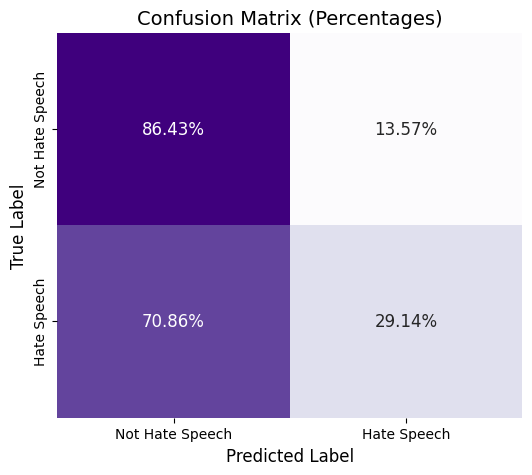

                 precision    recall  f1-score   support

Not Hate Speech       0.55      0.86      0.67      1894
    Hate Speech       0.68      0.29      0.41      1894

       accuracy                           0.58      3788
      macro avg       0.62      0.58      0.54      3788
   weighted avg       0.62      0.58      0.54      3788



In [45]:
test_predictions = model.predict(test_padded)
predicted_labels = np.argmax(test_predictions, axis=1)
cm = confusion_matrix(test_labels, predicted_labels)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
cm_df = pd.DataFrame(cm_percentage, index=["Not Hate Speech", "Hate Speech"], columns=["Not Hate Speech", "Hate Speech"])
cm_percentage_annot = cm_df.applymap(lambda x: f"{x:.2f}%")
plt.figure(figsize=(6, 5))
sns.heatmap(cm_df, annot=cm_percentage_annot, fmt='', cmap='Purples', cbar=False, annot_kws={"size": 12})
plt.title('Confusion Matrix (Percentages)', fontsize=14)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

plt.show()
print(classification_report(test_labels, predicted_labels, target_names=["Not Hate Speech", "Hate Speech"]))


# Saving the model for inference

In [40]:
model.save('hate_speech_model.h5')

In [41]:
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w') as f:
    f.write(tokenizer_json)

from tensorflow.keras.preprocessing.text import tokenizer_from_json
with open('tokenizer.json') as f:
    tokenizer_json = f.read()
    tokenizer_1 = tokenizer_from_json(tokenizer_json)

In [43]:
from tensorflow.keras.models import load_model
loaded_model = load_model('hate_speech_model.h5')

In [44]:
def preprocess_raw_text(raw_text, tokenizer, maxlen=33):
    cleaned_text = clean_tweet(raw_text)
    text_sequence = tokenizer.texts_to_sequences([cleaned_text])
    text_padded = pad_sequences(text_sequence, maxlen=maxlen, padding='post')
    return text_padded

In [50]:
import numpy as np
raw_text = "I Hate #$%#$%Jewish%$#@%^^@#."
preprocessed_text = preprocess_raw_text(raw_text, tokenizer_1)
prediction = loaded_model.predict(preprocessed_text)
label_index = np.argmax(prediction[0])
label = "Hate Speech" if label_index == 1 else "Not Hate Speech"
print(f"Prediction: {label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction: Hate Speech


In [47]:
raw_text = "i am amazing. #i_am #positive #affirmation"
raw_text = "i get to see my daddy today!!   #80days #gettingfed"
preprocessed_text = preprocess_raw_text(raw_text, tokenizer_1)
prediction = loaded_model.predict(preprocessed_text)
label_index = np.argmax(prediction[0])

label = "Hate Speech" if label_index == 1 else "Not Hate Speech"

print(f"Prediction: {label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Prediction: Not Hate Speech
